In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import npts

DATA_DIR = 'data/'

## (Down)load SFO weather data 

In [2]:
# import urllib.request

# for year in range(1987, 2019):
#     print(f"Downloading data for year {year}")
#     urllib.request.urlretrieve(f"https://www.ncei.noaa.gov/data/global-hourly/access/{year}/72494023234.csv", 
#                                DATA_DIR + f"{year}-SFO-weather.csv")

def load_year(year):
    ## Look at the document in DATA_DIR for spec.
    data=pd.read_csv(DATA_DIR+f'{year}-SFO-weather.csv.gz', usecols=[1,13])
    data.index = pd.to_datetime(data.DATE, format='%Y-%m-%dT%H:%M:%S')
    data = data.dropna()
    data['temp'] = data.TMP.apply(lambda el: float(el.split(',')[0])/10.)
    data['qual_code'] = data.TMP.apply(lambda el: (el.split(',')[1]))
    # time zone
    import pytz
    pacific = pytz.timezone('US/Pacific')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(pacific)

    return data.temp[data.qual_code.isin(['1','5'])]

temperatures = pd.Series()
for year in range(1987, 2019):
    temperatures = temperatures.append(load_year(year))

## Make independent test set

In [307]:
len(data_used)

294524

In [3]:
print('we have years:', set(temperatures.index.year))
data_used = temperatures[temperatures.index.year <= 2015]
indep_test = temperatures[temperatures.index.year > 2015]

we have years: {1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018}


## Train models on data 

In [4]:
# columns: constant, daily avg., annual avg., daily-annual avg., daily-annual bas.
# rows: full data, 50% data, 10% data, 1% data, 0.1% data, 0.01% data

### Experiment 

In [18]:
data = pd.DataFrame(temperatures)

data['dayofyear'] = data.index.dayofyear
data['hour'] = data.index.hour

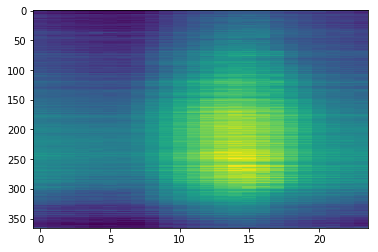

In [301]:
matrix = data[:].groupby(('dayofyear', 'hour')).mean().unstack().values
plt.imshow(matrix, aspect='auto')

In [302]:
# demeaned = matrix - matrix.mean()
# normalized = demeaned/demeaned.std()

/Users/enzo/anaconda3/envs/pytimeseries-env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


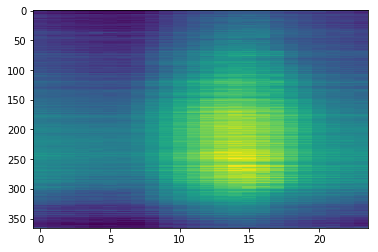

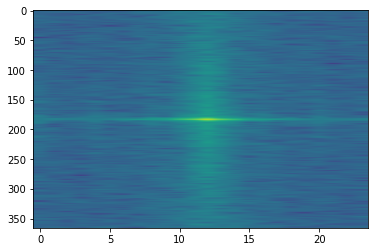

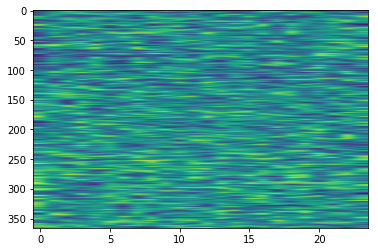

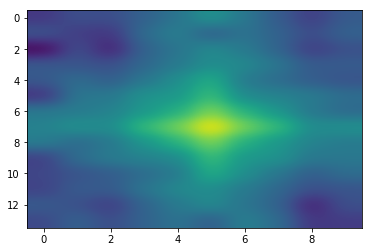

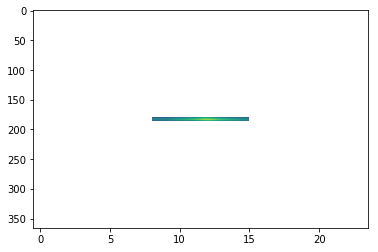

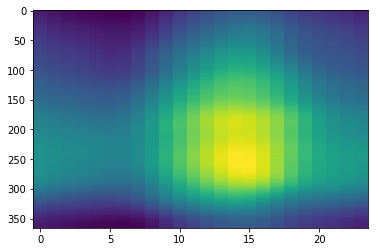

In [304]:
plt.imshow(matrix, aspect='auto')

transf = np.fft.fftshift(np.fft.fft2(matrix))

plt.figure()
plt.imshow(np.log(np.abs(transf)), aspect='auto', interpolation='gaussian')

plt.figure()
plt.imshow(np.angle(transf), aspect='auto', interpolation='gaussian')

win_year = 7
win_day = 5

low_pass = np.zeros_like(transf)
low_pass[183-win_year:183+win_year, 12-win_day:12+win_day] = \
transf[183-win_year:183+win_year,12-win_day:12+win_day]

plt.figure()
plt.imshow(np.log(np.abs(low_pass[183-win_year:183+win_year, 12-win_day:12+win_day])), aspect='auto', interpolation='gaussian')

plt.figure()
plt.imshow(np.log(np.abs(low_pass)), aspect='auto', interpolation='gaussian')

retransform = np.fft.ifft2(np.fft.ifftshift(low_pass))

plt.figure()
plt.imshow(np.real(retransform),aspect='auto')

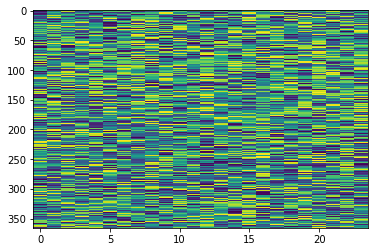

In [91]:
plt.imshow(np.angle(transf), aspect='auto')

In [308]:
import time

def constant_model(data, test):
    s = time.time()
    mean = np.mean(data)
    took_time = time.time() - s
    rmse = np.sqrt(np.mean((test - mean)**2))
    return rmse, took_time

def model_test_rmse(model, test):
    pred = model.predict(test.index)
    res = test - pred
    return np.sqrt(np.mean(res**2))
    
def daily_avg_model(data, test):
    s = time.time()
    #model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]))
    #model.fit(data, train_frac=1)
    model = data.groupby(data.index.hour).mean()
    took_time = time.time() - s
    res = test - model[test.index.hour].values
    res = res.fillna(method='pad').fillna(method='backfill')
    assert sum(np.isnan(res)) == 0.
    rmse = np.sqrt(res**2).mean(skipna=False)
    #rmse = model_test_rmse(model, test)
    return rmse, took_time

def annual_avg_model(data, test):
    s = time.time()
    model = data.groupby(data.index.dayofyear).mean()
    #model = npts.Baseline(npts.DayOfYear(lambdas=[1E-6]))
    #model.fit(data, train_frac=1)
    took_time = time.time() - s
    res = test - model[test.index.dayofyear].values
    res = res.fillna(method='pad').fillna(method='backfill')
    assert sum(np.isnan(res)) == 0.
    rmse = np.sqrt((res**2).mean(skipna=False))
    #rmse = model_test_rmse(model, test)
    return rmse, took_time

def daily_annual_avg_model(data, test):
    s = time.time()
#     model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]),
#                           npts.DayOfYear(lambdas=[1E-6]))
#     model.fit(data, train_frac=1)
    model = data.groupby((data.index.hour, data.index.dayofyear)).mean()
    took_time = time.time() - s
    res = test - model[zip(test.index.hour, test.index.dayofyear)].values
    res = res.fillna(method='pad').fillna(method='backfill')
    assert sum(np.isnan(res)) == 0.
    rmse = np.sqrt((res**2).mean(skipna=False))
    #rmse = model_test_rmse(model, test)
    return rmse, took_time

def daily_annual_bas_model(data, test):
    s = time.time()
    model = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 20)),
                          npts.DayOfYear(lambdas=np.logspace(-6,2, 20)))
    model.fit(data)
    took_time = time.time() - s
    return model_test_rmse(model, test), took_time


In [309]:
np.random.seed(0)
indep_test_rmse = pd.DataFrame()
time_taken_df = pd.DataFrame()

for data, dataname in [(data_used, '100% data'), 
                       (data_used[np.random.uniform(size=len(data_used)) < .5], '50% data'),
                      (data_used[np.random.uniform(size=len(data_used)) < .1], '10% data'),
                       (data_used[np.random.uniform(size=len(data_used)) < .05], '5% data'),
                      (data_used[np.random.uniform(size=len(data_used)) < .01], '1% data'),
                       (data_used[np.random.uniform(size=len(data_used)) < .005], '0.5% data'),
                      (data_used[np.random.uniform(size=len(data_used)) < .001], '0.1% data'),
                      #(data_used[np.random.uniform(size=len(data_used)) < .0001], '0.01% data')
                      ]:
    for model, modelname in [(constant_model, 'constant'), 
                             (daily_avg_model, 'hour avg.'),
                            (annual_avg_model, 'day-of-year avg.'),
                            (daily_annual_avg_model, 'hour and day-of-year avg.'),
                            (daily_annual_bas_model, 'hour and day-of-year baseline')
                            ]:
        rmse, time_taken = model(data, indep_test)
        indep_test_rmse.loc[dataname, modelname] = rmse
        time_taken_df.loc[dataname, modelname] = time_taken

building reg matrices
building reg matrices
building reg matrices
building reg matrices
building reg matrices


/Users/enzo/anaconda3/envs/pytimeseries-env/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


building reg matrices
building reg matrices
building reg matrices


In [8]:
indep_test_rmse

,constant,daily avg.,annual avg.,daily-annual avg.,daily-annual bas.
full data,3.939769,3.400739,3.273761,2.551503,2.544156
0.1% data,3.892625,3.457625,4.225754,3.024344,2.656069


In [313]:
print(indep_test_rmse.iloc[:-1].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  constant &  hour avg. &  day-of-year avg. &  hour and day-of-year avg. &  hour and day-of-year baseline \\
\midrule
100\% data &     3.940 &      2.628 &             3.274 &                      2.552 &                          2.544 \\
50\% data  &     3.939 &      2.626 &             3.273 &                      2.586 &                          2.541 \\
10\% data  &     3.945 &      2.633 &             3.298 &                      2.936 &                          2.564 \\
5\% data   &     3.937 &      2.625 &             3.300 &                      3.188 &                          2.563 \\
1\% data   &     3.952 &      2.660 &             3.501 &                      3.366 &                          2.617 \\
0.5\% data &     3.910 &      2.610 &             3.736 &                      3.510 &                          2.611 \\
0.1\% data &     3.999 &      2.868 &             3.955 &                      3.424 &                          2.784 \

In [11]:
time_taken_df

,constant,daily avg.,annual avg.,daily-annual avg.,daily-annual bas.
full data,0.001109,0.048422,0.054550,0.112360,22.415531
50% data,0.000550,0.028748,0.021103,0.042113,20.689101
10% data,0.000194,0.011296,0.003905,0.008867,22.532359
1% data,0.000113,0.002335,0.001224,0.002863,28.028848
0.1% data,0.000118,0.001411,0.000885,0.001738,27.139220
0.01% data,0.000137,0.001104,0.001462,0.002032,33.476779


## Inspect baseline fit on 0.1% of data 

In [315]:
np.random.seed(0)
mask = np.random.uniform(size=len(data_used)) < .001
small_data = data_used[mask]

baseline_small_data = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-8,5, 30)), 
                         npts.DayOfYear(lambdas=np.logspace(-8,5, 30)))

baseline_small_data.fit(small_data)

building reg matrices


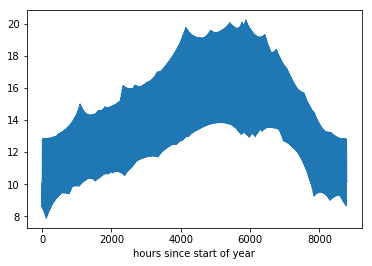

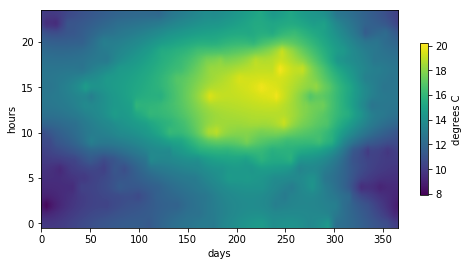

In [333]:
def plot_2d_model(theta):
    
    plt.figure()
    plt.plot(theta)
    plt.xlabel('hours since start of year')

    fig = plt.figure(figsize=(8,4))
    cax = plt.imshow(theta.reshape((366,24)).T, 
                     aspect='auto',origin='lower',interpolation='gaussian')
    axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7, label='degrees C')
    plt.xlabel('days')
    plt.ylabel('hours')

plot_2d_model(baseline_small_data.theta)
plt.savefig('../../non_par_ts/temperatures_baseline.pdf')

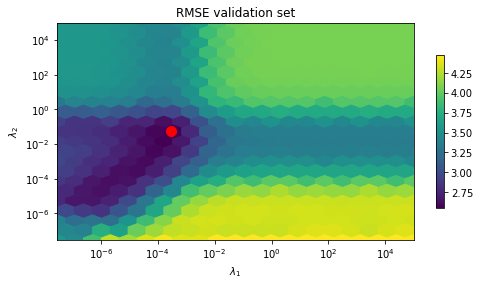

In [341]:
def plot_RMSE(baseline, cost_dict, title):
    fig = plt.figure(figsize=(8,4))
    cax = plt.hexbin(*np.array([[*k,np.sqrt(v)] for k, v 
                          in cost_dict.items() if np.alltrue(np.log10(k) > -8)]).T,
                     xscale='log',
                     yscale='log',
              gridsize=20)
    axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
    plt.loglog(*(baseline.best_lambda), 'ro', markersize=10)
    plt.xlabel('$λ_1$')
    plt.ylabel('$λ_2$')
    plt.title(title)
    
plot_RMSE(baseline_small_data, baseline_small_data.val_costs, 'RMSE validation set')
plt.savefig('../../non_par_ts/temperatures_rmse.pdf')

### Comparison on test RMSE 

In [32]:
# def model_test_rmse(model, test_data):
#     pred = model.predict(test_data.index)
#     res = test_data - pred
#     return np.sqrt(np.mean(res**2))

# print(pd.Series(name=r'Indep. test RMSE',
#           index = ['Constant',
#                    'Hourly average',
#                    'Annual (day-of-year) avg.',
#               'Monthly-hourly avg.',
#                    'Annual-hourly avg.',
#                    'Annual-hourly baseline',
#                   'Annual-hourly bas., 50% data',
#                    'Annual-hourly avg., 50% data',
#                   'Annual-hourly bas., 10% data',
#                   'Annual-hourly bas., 1% data',
#                   'Annual-hourly bas., 0.1% data',
#                   'Annual-hourly bas., 0.01% data'],
#           data=[np.sqrt(np.mean((indep_test - constant)**2)),
#                 model_test_rmse(daily_average, indep_test),
#                 model_test_rmse(annual_average, indep_test),
#                 model_test_rmse(reduced_average, indep_test),
#                 model_test_rmse(full_average, indep_test),
#                 model_test_rmse(full_baseline, indep_test),
#                model_test_rmse(half_baseline, indep_test),
#                model_test_rmse(half_average, indep_test),
#                model_test_rmse(ten_pc_baseline, indep_test),
#                model_test_rmse(one_pc_baseline, indep_test),
#                model_test_rmse(zero_one_pc_baseline, indep_test),
#                model_test_rmse(zero_zero_one_pc_baseline, indep_test)]).to_latex(float_format = '%.3f'))

## Error

In [33]:
# residuals = np.abs(train - baseline.predict(train.index))

# res_baseline = npts.Baseline(npts.HourOfDay(lambdas=[baseline.best_lambda[0]]),#np.logspace(-6,-1, 20)), 
#                              npts.DayOfYear(lambdas=[baseline.best_lambda[1]]))#np.logspace(-7,-1, 20)))

# res_baseline.fit(residuals)#, initial_lambda = baseline.best_lambda)

In [34]:
# residuals = train - baseline.predict(train.index)
# abs_sigmas = (res_baseline.predict(train.index))

# (residuals/abs_sigmas).kurtosis()

In [35]:
# #res_baseline.theta = np.sqrt(res_baseline.theta)

# plt.plot((res_baseline.theta))

# fig = plt.figure()
# cax = plt.imshow((res_baseline.theta.reshape((366,24))).T, aspect='auto',origin='lower')
# axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)

## Error squared 

In [36]:
residuals_squared = (small_data - baseline_small_data.predict(small_data.index))**2

res_sq_baseline = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 30)), 
                             npts.DayOfYear(lambdas=np.logspace(-6,2, 30)))

res_sq_baseline.fit(residuals_squared)

building reg matrices


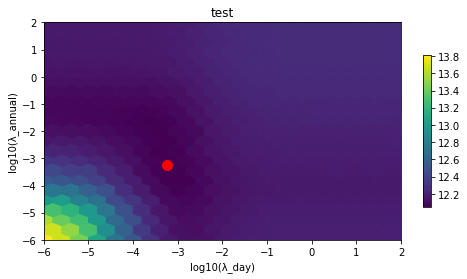

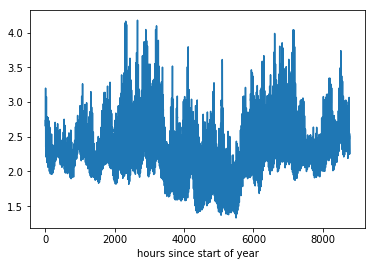

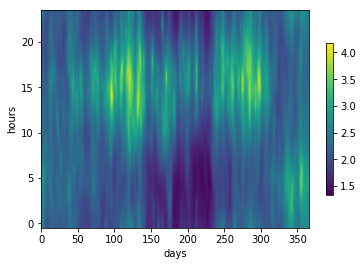

In [37]:
plot_RMSE(res_sq_baseline, res_sq_baseline.val_costs, 'test')
plot_2d_model(np.sqrt(res_sq_baseline.theta))

In [38]:
# #res_baseline.theta = np.sqrt(res_baseline.theta)

# plt.plot(np.sqrt(res_sq_baseline.theta))

# fig = plt.figure()
# cax = plt.imshow(np.sqrt(res_sq_baseline.theta.reshape((366,24))).T, aspect='auto',origin='lower')
# axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)

### Prediction on sample days 

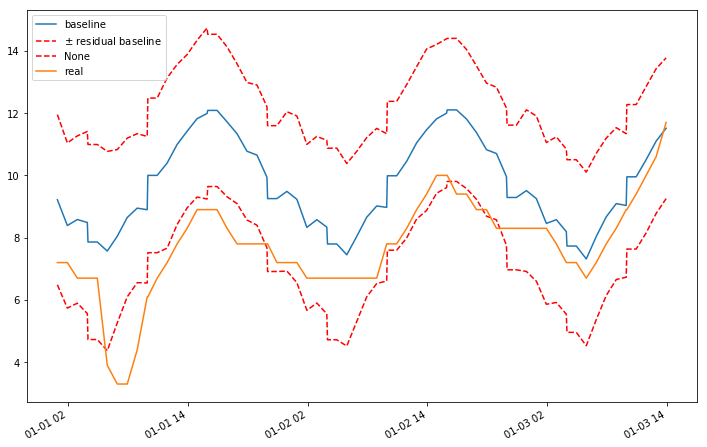

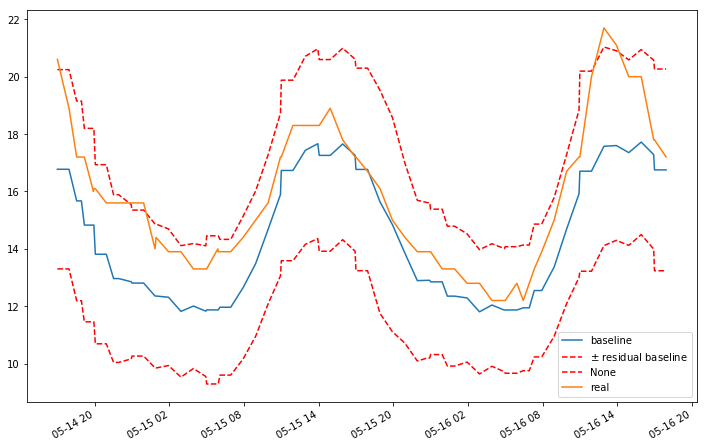

In [54]:
win_data = indep_test[24*0:24*3]

plt.figure(figsize=(12,8))
one_pc_baseline.predict(win_data.index).plot(label='baseline')
(one_pc_baseline.predict(win_data.index) + np.sqrt(res_sq_baseline.predict(win_data.index))).plot(label='$\pm$ residual baseline',
                                                                                 style='r--')
(one_pc_baseline.predict(win_data.index) - np.sqrt(res_sq_baseline.predict(win_data.index))).plot(style='r--')
win_data.plot(label='real')
plt.legend()

win_data = indep_test[24*180:24*183]

plt.figure(figsize=(12,8))
one_pc_baseline.predict(win_data.index).plot(label='baseline')
(one_pc_baseline.predict(win_data.index) + np.sqrt(res_sq_baseline.predict(win_data.index))).plot(label='$\pm$ residual baseline',
                                                                                 style='r--')
(one_pc_baseline.predict(win_data.index) - np.sqrt(res_sq_baseline.predict(win_data.index))).plot(style='r--')
win_data.plot(label='real')
plt.legend()



In [39]:
# residuals = test - baseline.predict(test.index)
# sigmas = np.sqrt(res_sq_baseline.predict(test.index))

# normalized = (residuals/sigmas)

# normalized.kurtosis()

In [40]:
# residuals.hist(bins=400)

In [41]:
# import matplotlib.mlab as mlab

# xs = np.arange(-4,4,.01)

# bins=normalized.hist(bins=400)

# l = plt.plot(xs, mlab.normpdf( xs, 0, 1)*1000, 'r--', linewidth=2)

In [42]:
# residuals.kurtosis()

In [43]:
# xs = np.arange(-10,10,.01)

# bins=residuals.hist(bins=400)

# l = plt.plot(xs, mlab.normpdf( xs, residuals.mean(), residuals.std())*28000, 'r--', linewidth=2)